# Average Approach

Benchmark model that simply forecasts the average historical value.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-wind_speed.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,3.0,4.0,2.0,4.0,7.0,4.0,6.0,2.0,8.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,4.0,5.0,4.0,6.0,3.0,3.0,7.0,4.0,5.0,1.0,3.0,2.0,7.0,1.0,0.0,3.0,4.0,4.0,0.0
2017-03-25 02:00:00,3.0,4.0,3.0,5.0,6.0,1.0,7.0,2.0,5.0,1.0,2.0,4.0,5.0,4.0,4.0,4.0,8.0,3.0,3.0,1.0,3.0,3.0,2.0,6.0,4.0,6.0,2.0,3.0,2.0,6.0,1.0,0.0,5.0,4.0,4.0,0.0
2017-03-25 03:00:00,2.0,3.0,3.0,3.0,5.0,1.0,7.0,3.0,6.0,0.0,2.0,2.0,5.0,2.0,4.0,4.0,2.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,3.0,3.0,2.0,3.0,1.0,5.0,1.0,1.0,3.0,4.0,4.0,1.0
2017-03-25 04:00:00,2.0,3.0,3.0,4.0,2.0,4.0,3.0,1.0,1.0,0.0,2.0,3.0,10.0,2.0,4.0,5.0,5.0,3.0,4.0,2.0,4.0,2.0,2.0,5.0,4.0,3.0,2.0,2.0,1.0,5.0,1.0,1.0,6.0,0.0,0.0,1.0
2017-03-25 05:00:00,2.0,2.0,3.0,4.0,5.0,2.0,2.0,1.0,4.0,1.0,2.0,6.0,2.0,3.0,2.0,4.0,7.0,2.0,3.0,2.0,3.0,3.0,2.0,6.0,3.0,2.0,2.0,4.0,1.0,6.0,1.0,1.0,4.0,3.0,3.0,1.0


## Define Parameters

Make predictions for 24-hour period using a training period of two weeks.

In [4]:
dataset_name = 'Hourly Weather Wind Speed'
dataset_abbr = 'HWS'
model_name = 'Average'
context_length = 24*7*2 # Two weeks
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Evaluate Average Approach Models

In [6]:
results = df.copy()
for i, col in enumerate(df.columns):
    results['pred%s' % str(i+1)] = results[col].iloc[-(context_length + prediction_length):-prediction_length].mean()
results.dropna(inplace=True)

In [7]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results[col].iloc[-prediction_length:],
                             results['pred%s' % str(i+1)].iloc[-prediction_length:]))

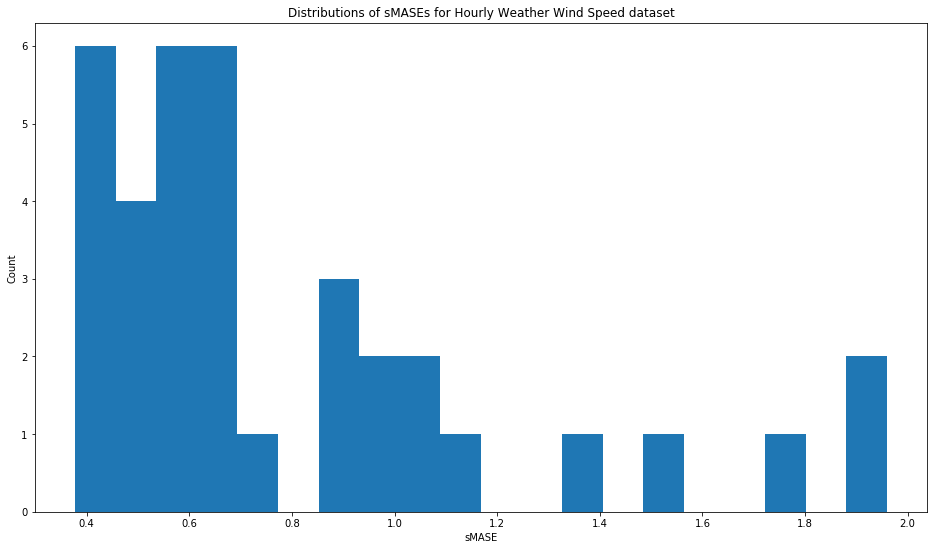

In [8]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [9]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 0.8139


Show some example forecasts.

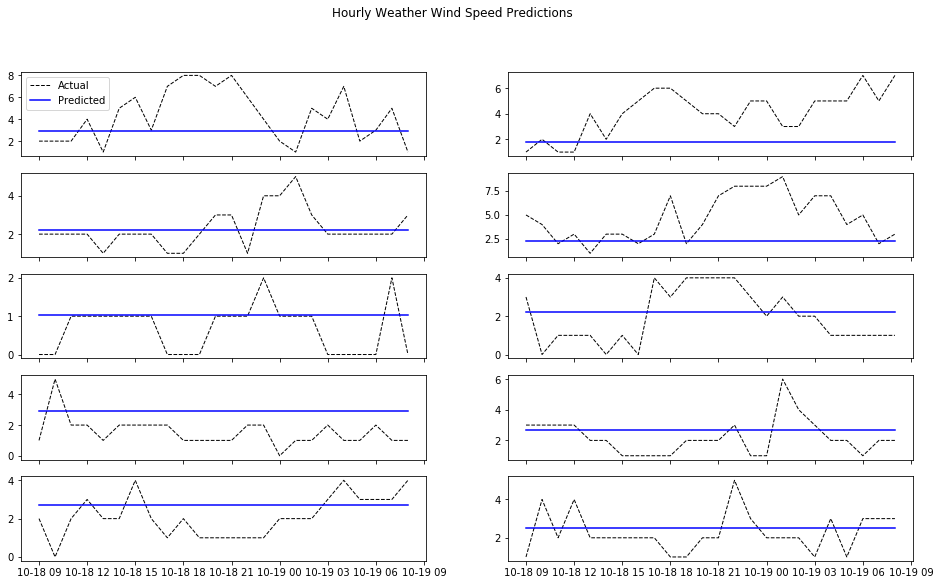

In [10]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results.index[-prediction_length:], results['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results.index[-prediction_length:], results['pred%s' % col].iloc[-prediction_length:],
                   label='Predicted', c='b')
fig.suptitle('{} Predictions'.format(dataset_name))
ax[0].legend();

Store the predictions and accuracy score for the Average Approach models.

In [11]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)